In [10]:
import os
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
data_path = '/kaggle/input/cassava-leaf-disease-classification'
train_img_path = os.path.join(data_path, "train_images")
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Train num: 21397
Label num: 
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


<Axes: >

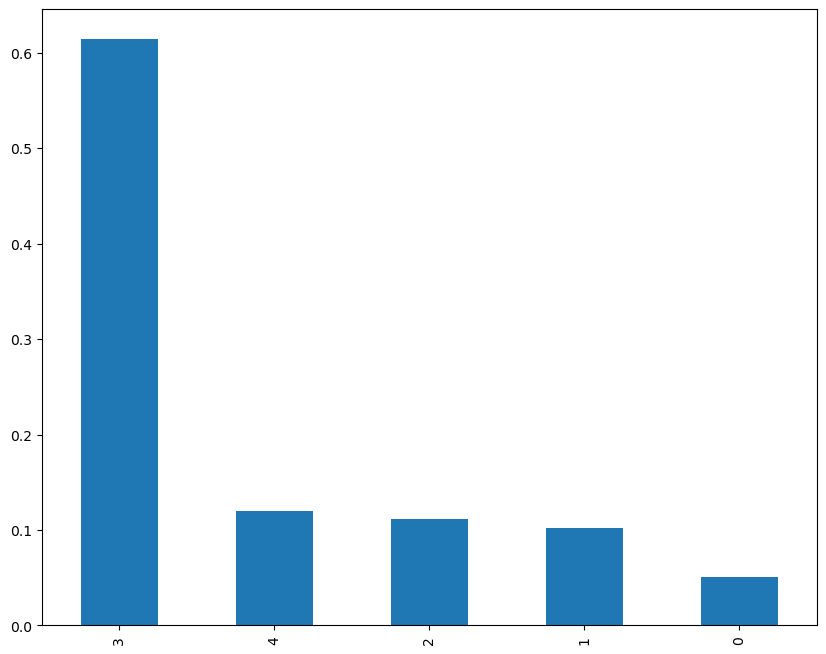

In [3]:
# EDA
# first, I check label of train data.
print("Train num: {}".format(len(train_df)))
print("Label num: ")
print((train_df["label"].value_counts()/len(train_df)))
fig = plt.figure(figsize=(10,8))
(train_df["label"].value_counts()/len(train_df)).plot(kind='bar')

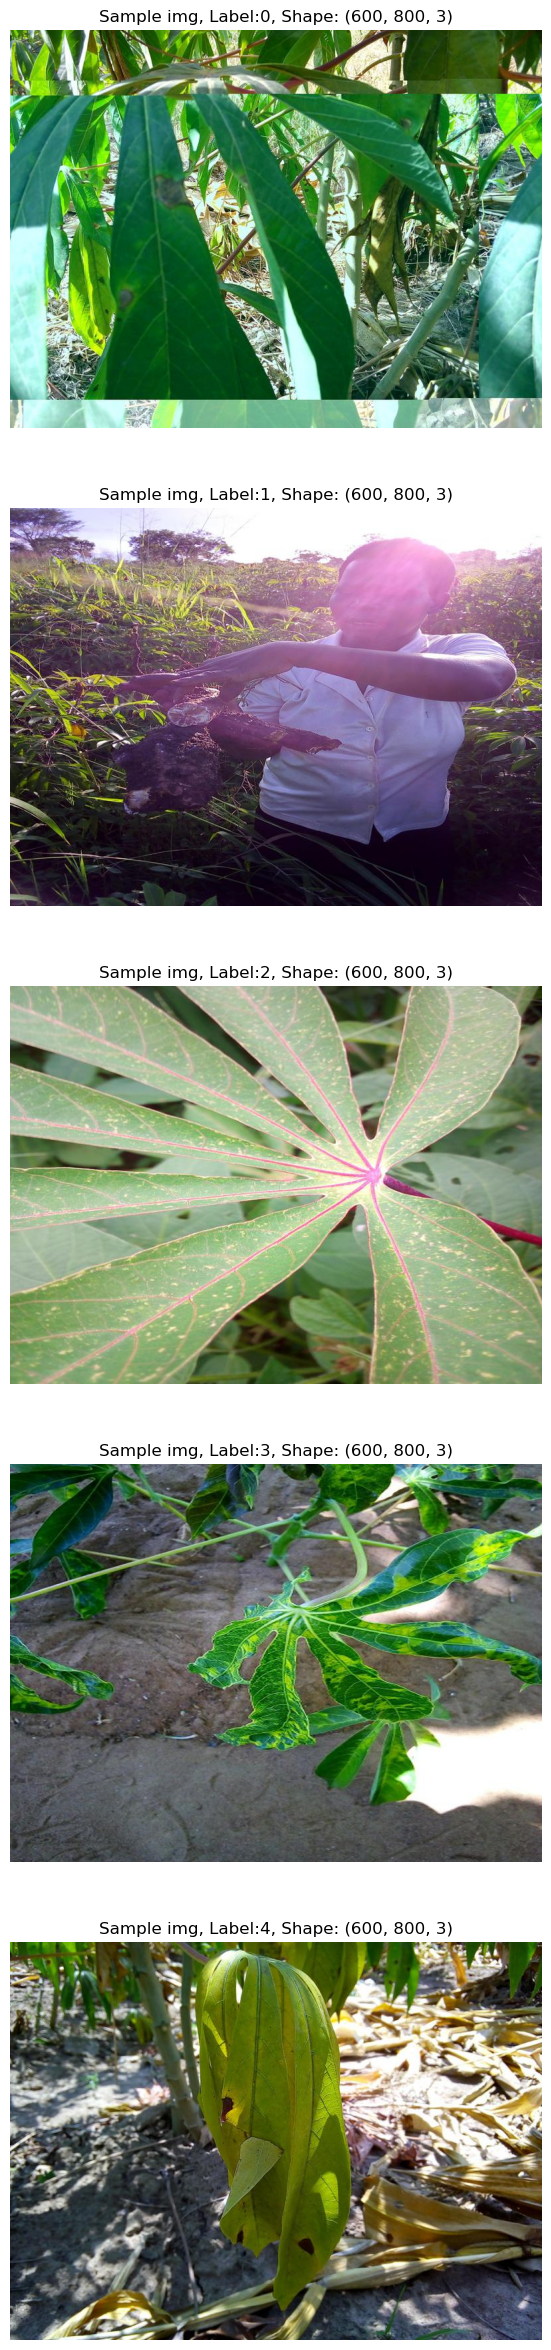

In [9]:
# check train images of each label
def plot_images(df:pd.DataFrame, train_img_path:str, figsize=(20, 30)):
    fig = plt.figure(figsize=figsize)
    len_label = len(df['label'].unique())
    
    for i in range(len_label):
        ax = fig.add_subplot(len_label, 1, i+1)
        sample = df[df['label']==i]['image_id'].sample().iloc[0]
        img = cv2.imread(os.path.join(train_img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Sample img, Label:{}, Shape: {}".format(i, img.shape))
        plt.axis("off")
    plt.show()
    
plot_images(train_df, train_img_path)

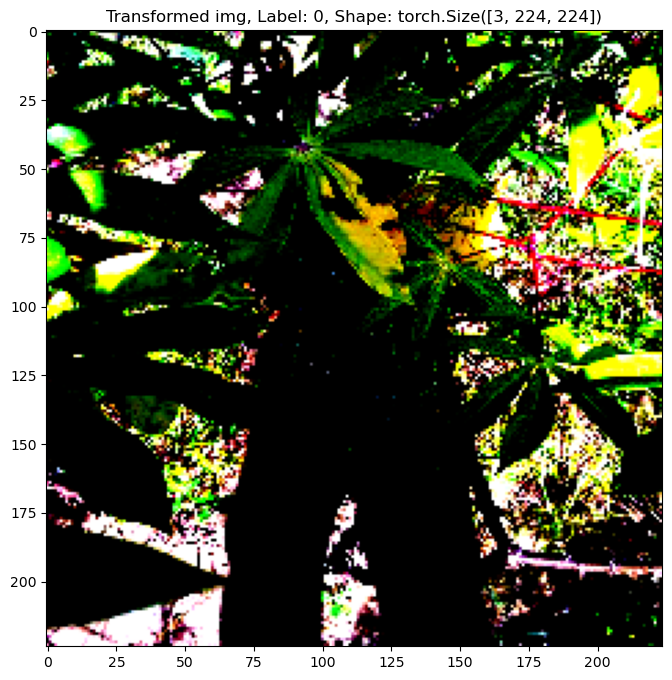

In [13]:
# create Dataset and Transform
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, img_path:str, phase:str='train', transform:object=None):
        self.df = df
        self.phase = phase
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        img = cv2.imread(os.path.join(self.img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(self.phase, img)
            
        if self.phase == 'test':
            return img
        
        label = self.df['label'].iloc[idx]
        
        return img, label
    
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
            'train':A.Compose([
                A.Resize(256, 256),
                A.RandomCrop(resize, resize, p=1.0),
                A.HorizontalFlip(),
                A.VerticalFlip(),
                A.ShiftScaleRotate(),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'val':A.Compose([
                A.Resize(256, 256),
                A.CenterCrop(resize, resize),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.Resize(256, 256),
                A.CenterCrop(resize, resize),
                A.Normalize(mean, std),
                ToTensorV2()
            ])
        }
    
    def __call__(self, phase, img):
        return self.transform[phase](image=img)['image']

# check moving of Dataset
resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(resize, mean, std)
dataset = CassavaDataset(train_df, train_img_path, transform=transform)
img, label = dataset.__getitem__(0)

fig = plt.figure(figsize=(10, 8))
plt.imshow(img.squeeze().numpy().transpose(1,2,0))
plt.title('Transformed img, Label: {}, Shape: {}'.format(label, img.size()))
plt.show()

In [22]:
# create Squeeze model
class FireModule(nn.Module):
    def __init__(self, in_channel, squeeze_channel, conv11_channel, conv33_channel):
        super().__init__()
        self.squeeze_layer = nn.Conv2d(in_channel, squeeze_channel, kernel_size=1, stride=1, bias=False)
        self.squeeze_activation = nn.ReLU(inplace=True)
        
        self.expansion11_layer = nn.Conv2d(squeeze_channel, conv11_channel, kernel_size=1, stride=1, bias=False)
        self.expansion11_activation = nn.ReLU(inplace=True)
        
        self.expansion33_layer = nn.Conv2d(squeeze_channel, conv33_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.expansion33_activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.squeeze_layer(x)
        x = self.squeeze_activation(x)
        
        branch1 = self.expansion11_layer(x)
        branch1 = self.expansion11_activation(branch1)
        
        branch2 = self.expansion33_layer(x)
        branch2 = self.expansion33_activation(branch2)
        
        return torch.concat([branch1, branch2], 1)
    
class SqueezeNet(nn.Module):
    def __init__(self, num_classes=5, drop_rate=0.5):
        super().__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),  
                nn.ReLU(inplace=True),  
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                FireModule(96, 16, 64, 64),  
                FireModule(128, 16, 64, 64),  
                FireModule(128, 32, 128, 128),  
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True), 
                FireModule(256, 32, 128, 128), 
                FireModule(256, 48, 192, 192),  
                FireModule(384, 48, 192, 192), 
                FireModule(384, 64, 256, 256), 
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                FireModule(512, 64, 256, 256),
                nn.Dropout(p=drop_rate), 
            )
            
        final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        final_conv.stddev = 0.01
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), 
            final_conv,  
            nn.ReLU(inplace=True),  
            nn.AdaptiveAvgPool2d((1, 1)),  
        )

        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if hasattr(m, "stddev"):
                    torch.nn.init.normal_(m.weight, std=m.stddev)
                else:
                    torch.nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

model = SqueezeNet()
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): FireModule(
      (squeeze_layer): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (squeeze_activation): ReLU(inplace=True)
      (expansion11_layer): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (expansion11_activation): ReLU(inplace=True)
      (expansion33_layer): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (expansion33_activation): ReLU(inplace=True)
    )
    (4): FireModule(
      (squeeze_layer): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (squeeze_activation): ReLU(inplace=True)
      (expansion11_layer): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (expansion11_activation): ReLU(inplace=True)
      (expansion33_layer): Conv2d(16, 64, ke

In [ ]:
def train_model(model, dl_dict, critetion, optimizer, device, epochs=5, scheduler=None):
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
        
    for epoch in range(epochs):
        print("{}/{}".format(epoch, epochs))
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dl_dict[phase]):
                model = model.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels)
            
            epoch_loss = running_loss/len(dl_dict[phase].dataset)
            epoch_acc = running_corrects/len(dl_dict[phase].dataset)
            
            if phase == 'train' and scheduler != None:
                scheduler.step(loss)
                
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_squeeze.pth')
                
            print("{} Loss:{:4f}, Acc:{:4f}".format(phase, running_loss, running_acc))
        print()
    
    time_elapced = time.time() - since
    print('Train complete: {}m {}s'.format(time_elapced//60, time_elapced%60))
    print('Val best acc: {}'.format(best_acc))
    
train, val = train_test_split(train_df, test_size=0.2, random_state=1, stratify=train_df['label'])
train_dataset = CassavaDataset(train, train_img_path, transform=transform)
val_dataset = CassavaDataset(val, train_img_path, 'val', transform)
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)
dl_dict = {'train': train_dl, 'val':val_dl}
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, verbose=True, factor=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5
train_model(model, dl_dict, criterion, optimizer, device, epochs, scheduler)

0/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load(os.path.join(data_path, 'baseline-senet/best_squeeze.pth')))
model = model.to(device)
model.eval()

test_img_path = os.path.join(data_path, 'test_images')
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
test_dataset = CassavaDataset(test_df, test_img_path, phase='test', transform=transform)
test_dl = DataLoader(test_dataset, batch_size=1, shuffle=False)

preds = []

for inputs in test_dl:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    preds.append(pred)
    
test_df['label'] = np.concatenate(preds)
test_df.to_csv('submission.csv')